In [1]:
# import nltk
# nltk.download("twitter_samples")

In [39]:
import nltk
corpus = "brown"
nltk.download(corpus)
corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/tollef/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [48]:
from collections import defaultdict
topics = defaultdict(list)
for cat in corpus.categories():
    print(cat)
    # get all documents from a category
    docs = corpus.fileids(cat)
    print(len(docs))
    for cat_fileid in docs:
        words = corpus.words(cat_fileid)
        topics[cat].append(words)

adventure
29
belles_lettres
75
editorial
27
fiction
29
government
30
hobbies
36
humor
9
learned
80
lore
48
mystery
24
news
44
religion
17
reviews
17
romance
29
science_fiction
6


In [49]:
topics["romance"]

[['They', 'neither', 'liked', 'nor', 'disliked', 'the', ...],
 ['People', 'came', 'in', 'and', 'out', 'all', ...],
 ['``', 'Thrifty', 'of', 'her', 'to', 'use', 'it', 'up', ...],
 ['``', 'He', 'must', 'have', 'forgiven', 'me', "''", ...],
 ['The', 'Momoyama', 'family', 'had', 'come', 'from', ...],
 ['How', ',', 'he', 'wondered', ',', 'does', 'one', ...],
 ['Spencer', 'said', 'nothing', '.', '``', 'Is', ...],
 ['Rachel', 'steered', 'me', 'along', 'toward', 'a', ...],
 ['``', 'And', "I'll", 'take', 'you', 'with', 'me', ...],
 ['Among', 'us', ',', 'we', 'three', 'handled', 'quite', ...],
 ['Such', 'a', 'little', 'thing', 'to', 'start', 'with', ...],
 ['``', 'I', 'had', 'a', 'rather', 'small', 'place', ...],
 ['But', 'one', 'night', 'Dookiyoon', 'moved', 'in', ...],
 ['She', 'was', 'moving', 'through', 'a', 'screen', ...],
 ['``', 'They', 'make', 'us', 'conformists', 'look', ...],
 ['Unimpressed', ',', 'the', 'dog', 'plopped', 'on', ...],
 ['When', 'Bobbie', 'Evans', 'smashed', 'up', 'his',

In [50]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.WordNetLemmatizer()

def simple_preprocessing(text):
    text = text.lower()
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[\n\t]", " ", text)
    text = re.sub(r" +", " ", text)
    text = re.sub(r"[^a-z ]", "", text)

    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords and len(token) >= 3]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

for category, documents in topics.items():
    for i, doc in enumerate(documents):
        topics[category][i] = simple_preprocessing(" ".join(doc))

In [55]:
# !pip install jsonlines
import jsonlines
with jsonlines.open("parsed_corpus.jsonl", "w") as writer:
    for category, documents in topics.items():
        for doc in documents:
            writer.write({"text": doc, "category": category})

In [57]:
# flatten
all_documents = []
for category, documents in topics.items():
    all_documents.extend(documents)
corpus = all_documents

In [58]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.5)
# min_df=10 means that the word must appear in at least 10 documents
# max_df=0.5 means that the word must not appear in more than 50% of the documents
X = vectorizer.fit_transform(corpus)
# print(X.toarray()[0:3])

In [25]:
X.shape

(65, 1524)

In [59]:
import numpy as np
np.random.seed(0)

N_TOPICS = 10
svd = TruncatedSVD(n_components=N_TOPICS, random_state=123)
latent_semantic_analysis = svd.fit_transform(X)

terms = vectorizer.get_feature_names_out()
N_TERMS = 5
for i, comp in enumerate(svd.components_):
    terms_in_comp = zip(terms, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x:x[1], reverse=True)[:N_TERMS]
    print("Topic "+str(i)+": ")
    print("|".join([t for t, _ in sorted_terms]))
    print(" ")

Topic 0: 
mr|house|school|eye|child
 
Topic 1: 
didnt|dont|eye|got|door
 
Topic 2: 
art|experience|literature|human|poem
 
Topic 3: 
system|temperature|cost|water|rate
 
Topic 4: 
mr|school|student|music|college
 
Topic 5: 
church|school|student|god|college
 
Topic 6: 
church|god|john|christ|christian
 
Topic 7: 
mr|church|god|house|john
 
Topic 8: 
tax|company|sale|music|jazz
 
Topic 9: 
game|mr|baseball|ball|player
 


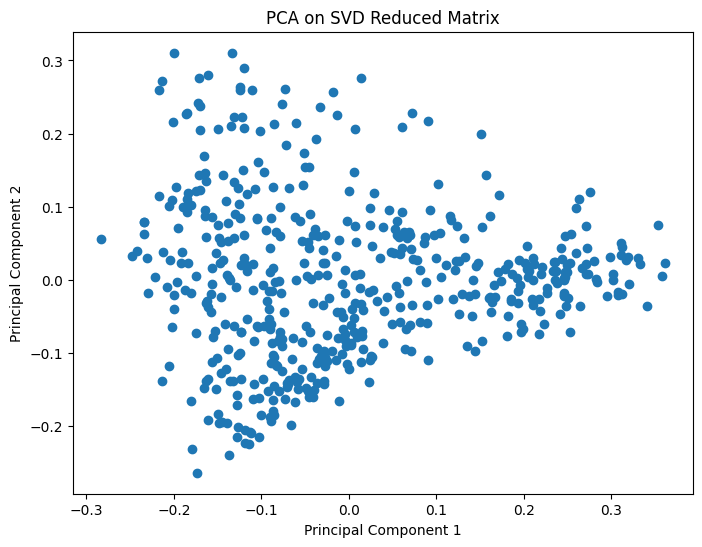

In [61]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_semantic_analysis)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on SVD Reduced Matrix')
plt.show()


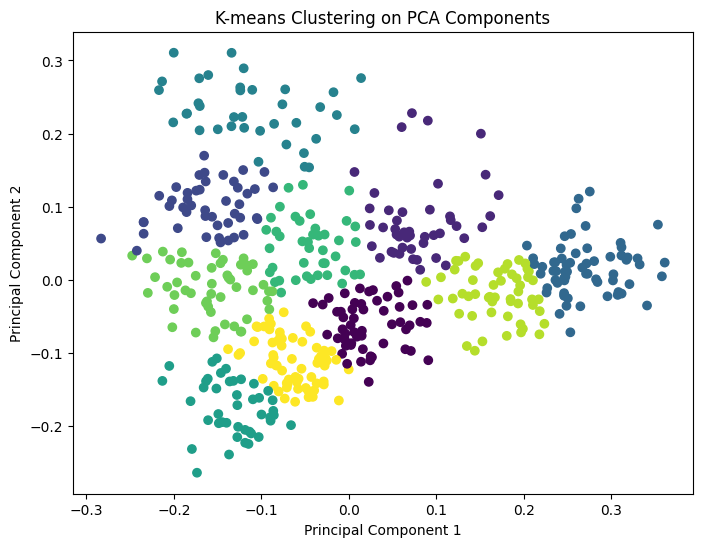

In [62]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=N_TOPICS, random_state=123)
kmeans.fit(pca_result)

# Get the cluster assignments
cluster_assignments = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_assignments)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on PCA Components')
plt.show()


In [68]:
# for i in range(N_TOPICS):
#     print(f"Cluster {i}")
#     cluster_indices = np.where(cluster_assignments == i)[0]
#     for j in range(5):
#         print(corpus[cluster_indices[j]])
#     print("\n\n")